In [1]:
# https://www.tensorflow.org/tutorials/text/image_captioning
# https://www.kaggle.com/code/dschettler8845/bms-image-captioning-w-attention-train
# https://github.com/vuducnghia/attention-ocr
import sys
import tensorflow as tf
sys.path.append('..')
tf.get_logger().setLevel('ERROR')

# Check GPU working

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
print('Found GPU at:', device_name)
!nvcc -V

Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


# Data input pipeline

In [4]:
from dataset_handler import create_dataset, remove_rare_chars
DATASET_DIR = r'../../Dataset/trdg'
LABELS_PATH = r'../../Dataset/trdg/labels.txt'
FONT_PATH = r'../../Dataset/NomNaTong-Regular.ttf'
HEIGHT = 148
WIDTH = 32

## Load and remove records with rare characters

In [5]:
img_paths, labels, vocabs = create_dataset(DATASET_DIR, LABELS_PATH, min_length=6)
img_paths, labels, vocabs = remove_rare_chars(img_paths, labels, vocabs, threshold=2)
print('Number of images found:', len(img_paths))
print('Number of labels found:', len(labels))
print('Number of unique characters:', len(vocabs))
print('Characters present:', vocabs)

Number of images found: 4333
Number of labels found: 4333
Number of unique characters: 2347
Characters present: {'㐌': 387, '浪': 356, '朱': 296, '\U000f070b': 292, '𠊛': 262, '\U000f047c': 260, '尼': 256, '娘': 252, '𦋦': 248, '𢚸': 246, '吏': 236, '固': 231, '拱': 220, '之': 199, '埃': 195, '情': 194, '𠳒': 179, '買': 178, '群': 175, '芇': 173, '𠓨': 157, '欺': 154, '別': 149, '麻': 148, '花': 147, '𠬠': 146, '𧗱': 144, '爫': 143, '仙': 142, '𡗶': 138, '𠄩': 132, '塘': 129, '如': 127, '𦖑': 126, '浽': 123, '𠫾': 122, '命': 122, '時': 121, '渚': 120, '渃': 118, '饒': 116, '呐': 115, '払': 115, '強': 114, '分': 114, '傷': 109, '𡢐': 108, '些': 108, '冲': 107, '鐄': 106, '𫽄': 106, '𢬣': 104, '低': 104, '生': 102, '皮': 100, '於': 100, '𧡊': 99, '仍': 99, '身': 98, '咍': 98, '茹': 97, '庒': 95, '牢': 94, '𣈜': 94, '昆': 93, '調': 92, '沛': 89, '\U000f061a': 89, '緣': 88, '細': 87, '公': 86, '月': 85, '油': 84, '﨤': 84, '戈': 84, '典': 84, '爲': 83, '排': 81, '畧': 80, '催': 78, '㗂': 77, '包': 76, '碎': 75, '𠁀': 75, '\U000f02c7': 74, '貝': 70, '賒': 70, '𢪀': 69, '共'

## Visualize the data

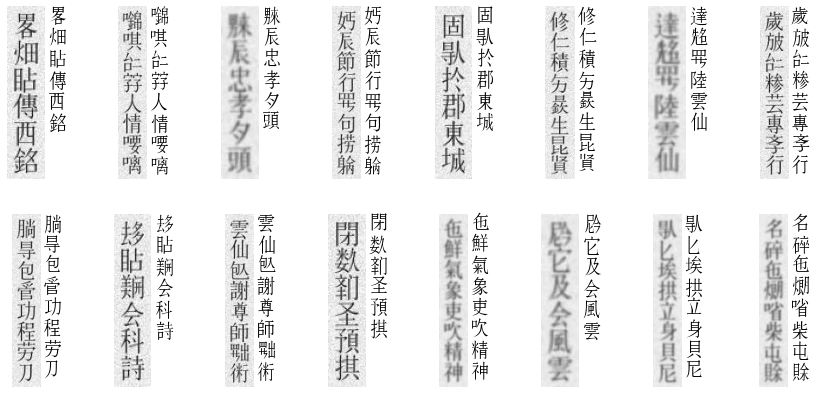

In [6]:
from visualizer import visualize_images_labels
visualize_images_labels(img_paths, labels, font_path=FONT_PATH, text_x=WIDTH + 3)

## Building the character vocabulary

In [7]:
# Mapping characters to integers
char2num = tf.keras.layers.StringLookup(
    vocabulary = list(vocabs) + ['[START]', '[END]'], 
    mask_token = '[PAD]',
)

# Mapping integers back to original characters
num2char = tf.keras.layers.StringLookup(
    vocabulary = char2num.get_vocabulary(), 
    mask_token = '[PAD]', 
    invert = True,
)

## Prepare `tf.data.Dataset` objects 

In [8]:
from dataset_handler import process_one_image
MAX_LENGTH = max([len(label) for label in labels]) + 2 # For [START] and [END] tokens
PADDING_TOKEN = char2num('[PAD]')
BATCH_SIZE = 16 
AUTOTUNE = tf.data.AUTOTUNE

In [9]:
def process_images_labels(img_path, label, img_size=(HEIGHT, WIDTH)):
    image = process_one_image(img_path, img_size)
    label = tf.strings.unicode_split(label, input_encoding='UTF-8')
    label = char2num(tf.concat([['[START]'], label, ['[END]']], 0))
    label_length = tf.shape(label, tf.int64)[0]
    label = tf.pad(
        label, 
        paddings = [[0, MAX_LENGTH - label_length]], 
        constant_values = PADDING_TOKEN
    )
    return image, label

In [10]:
def prepare_tf_dataset(img_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.repeat().batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

# Define the model

In [11]:
from tensorflow.keras.layers import Input, Embedding, Dense, GRU
from cnn import custom_cnn, get_imagenet_model, reshape_for_cnn
EMBEDDING_DIM = 512
UNITS = 512

In [12]:
imagenet_model, imagenet_output_layer = None, None
## Pick a model from https://keras.io/api/applications
# imagenet_model = get_imagenet_model('VGG16', (HEIGHT, WIDTH, 1))
# imagenet_output_layer = 'block4_pool'
# imagenet_model.summary(line_length=100)

## The encoder

In [13]:
def CNN_Encoder(imagenet_model=None, imagenet_output_layer=None, name='CNN_encoder'):
    if imagenet_model: # Use Imagenet model as CNN layers
        image_input = imagenet_model.input
        imagenet_model.layers[0]._name = 'image'
        x = imagenet_model.get_layer(imagenet_output_layer).output
    else: 
        image_input = Input(shape=(HEIGHT, WIDTH, 1), dtype='float32', name='image')
        conv_blocks_config = {
            'block1': {'num_conv': 1, 'filters':  64, 'pool_size': (2, 2)}, 
            'block2': {'num_conv': 1, 'filters': 128, 'pool_size': (2, 2)}, 
            'block3': {'num_conv': 2, 'filters': 256, 'pool_size': (2, 2)}, 
            'block4': {'num_conv': 2, 'filters': 512, 'pool_size': (1, 2)}, 
        }
        x = custom_cnn(conv_blocks_config, image_input)
    return tf.keras.Model(
        inputs = image_input, 
        outputs = reshape_for_cnn(x, dim_to_keep=-1), 
        name = name
    )

## The attention head

In [14]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, name='BahdanauAttention'):
        super(BahdanauAttention, self).__init__(name=name)
        self.W1 = Dense(UNITS)
        self.W2 = Dense(UNITS)
        self.V = Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 17, embedding_dim)
        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 17, units)
        attention_hidden_layer = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis)
        )

        # score shape == (batch_size, 17, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 17, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

## The decoder

In [15]:
def RNN_Decoder(enc_output_shape, vocab_size, name='RNN_Decoder'):
    token_input = Input(shape=(1,), name='new_token')
    features_input = Input(shape=enc_output_shape, name='encoder_output')
    pre_hidden_input = Input(shape=(UNITS,), name='pre_hidden_state')
    
    # Defining attention as a separate model
    attention = BahdanauAttention()
    context_vector, attention_weights = attention(features_input, pre_hidden_input)
    
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    # If mask_zero = True, index 0 cannot be used in the vocabulary,
    # (input_dim should equal size of vocabulary + 1)
    x = Embedding(vocab_size + 1, EMBEDDING_DIM, mask_zero=True)(token_input)
    
    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    
    # Passing the concatenated vector to the GRU
    rnn_output, state = GRU(
        units = UNITS, 
        return_state = True, 
        return_sequences = True, 
        recurrent_initializer = 'glorot_uniform',
    )(x, initial_state=pre_hidden_input)

    # shape == (batch_size, max_length, hidden_size)
    x = Dense(UNITS, name='dense')(rnn_output)
    
    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))
    
    # output shape == (batch_size * max_length, vocab)
    y_pred = Dense(vocab_size, name='prediction')(x)

    return tf.keras.Model(
        inputs = [token_input, features_input, pre_hidden_input], 
        outputs = [y_pred, state, attention_weights],
        name = name
    )

## Loss function and the Attention CRNN model 

In [16]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
loss_func = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def masked_loss(y_true, y_pred):
    loss = loss_func(y_true, y_pred)
    mask = tf.math.logical_not(tf.math.equal(y_true, PADDING_TOKEN))
    mask = tf.cast(mask, dtype=loss.dtype)
    
    # The PADDING_TOKEN need to be 0 for SparseCategoricalCrossentropy
    # See https://stackoverflow.com/questions/63171001 if loss == nan
    return tf.reduce_mean(loss * mask)

In [17]:
class AttentionCRNN(tf.keras.Model):
    def __init__(self, encoder, decoder, name='AttentionCRNN'):
        super(AttentionCRNN, self).__init__(name=name)
        self.encoder = encoder
        self.decoder = decoder
    
    def get_config(self):
        return {
            'encoder': CNN_Encoder(imagenet_model, imagenet_output_layer), 
            'decoder': RNN_Decoder(encoder.output_shape[1:], char2num.vocab_size())
        }
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
    @tf.function
    def _compute_loss(self, batch_inputs):
        dec_input = tf.expand_dims([char2num('[START]')] * BATCH_SIZE, 1) 
        hidden = tf.zeros((BATCH_SIZE, UNITS), tf.float32)
        
        batch_images, batch_labels = batch_inputs
        features = self.encoder(batch_images)
        loss = 0
        
        for i in range(1, MAX_LENGTH):
            # Passing the features through the decoder
            predictions, hidden, _ = self.decoder([dec_input, features, hidden])
            loss += masked_loss(batch_labels[:, i], predictions)

            # Use teacher forcing
            dec_input = tf.expand_dims(batch_labels[:, i], 1) 
        return loss, loss / MAX_LENGTH 

    @tf.function
    def train_step(self, batch_inputs):
        with tf.GradientTape() as tape:
            loss, average_loss = self._compute_loss(batch_inputs)
            
        # Apply an optimization step
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {'loss': average_loss}
    
    @tf.function
    def test_step(self, batch_inputs):
        loss, average_loss = self._compute_loss(batch_inputs)
        return {'loss': average_loss}

## Summary

In [18]:
encoder = CNN_Encoder(imagenet_model, imagenet_output_layer)
decoder = RNN_Decoder(encoder.output_shape[1:], char2num.vocab_size())
model = AttentionCRNN(encoder, decoder)

In [19]:
encoder.summary(line_length=93)
print()
decoder.summary(line_length=125)

Model: "CNN_encoder"
_____________________________________________________________________________________________
 Layer (type)                            Output Shape                          Param #       
 image (InputLayer)                      [(None, 148, 32, 1)]                  0             
                                                                                             
 block1_conv1 (Conv2D)                   (None, 148, 32, 64)                   640           
                                                                                             
 block1_bn1 (BatchNormalization)         (None, 148, 32, 64)                   256           
                                                                                             
 block1_activation1 (LeakyReLU)          (None, 148, 32, 64)                   0             
                                                                                             
 block1_pool (MaxPooling2D)            

                                                                                                                             
 dense (Dense)                           (None, 1, 512)             262656         ['gru[0][0]']                             
                                                                                                                             
 tf.reshape (TFOpLambda)                 (None, 512)                0              ['dense[0][0]']                           
                                                                                                                             
 prediction (Dense)                      (None, 2351)               1206063        ['tf.reshape[0][0]']                      
                                                                                                                             
Total params: 5,561,136
Trainable params: 5,561,136
Non-trainable params: 0
__________________________________________

# Training

In [20]:
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from custom_callbacks import EditDistanceCallback, EarlyStoppingWithStuck
early_stopping_callback = EarlyStoppingWithStuck(patience=5)

def scheduler(epoch, lr):
    if epoch < 1 or (epoch % 5) > 0: return lr # Keeps lr for each 5 epochs
    return lr * tf.math.exp(-0.2) # Decreases it exponentially after that
schedule_lr_callback = LearningRateScheduler(scheduler, verbose=1)

# Reduce the learning rate once learning stagnates
reduce_lr_callback = ReduceLROnPlateau(
    monitor = 'val_loss', 
    patience = 2, # Reduce if no improvement after 2 epochs
    min_delta = 0.001, # The val_loss should at least improve 0.001
    min_lr = 1e-7, # Lower bound on the learning rate 
    factor = 0.5, # => new_lr = lr * factor
    verbose = 1
)

## Cross validation with K-Fold

In [21]:
from kfold import kfold_decorator
from tensorflow.keras.optimizers import Adam
LEARNING_RATE = 2e-4
EPOCHS = 100

In [22]:
@kfold_decorator(n_splits=10, random_state=2022, is_subclassed_model=True)
def train(model, img_paths, labels, train_idx=None, valid_idx=None):
    train_tf_dataset = prepare_tf_dataset(img_paths[train_idx], labels[train_idx])
    valid_tf_dataset = prepare_tf_dataset(img_paths[valid_idx], labels[valid_idx])

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE))
#     edit_distance_callback = EditDistanceCallback(Model(
#         inputs = model.get_layer('image').input, 
#         outputs = model.get_layer('prediction').output
#     ), valid_tf_dataset, MAX_LENGTH)
    
    history = model.fit(
        train_tf_dataset,
        validation_data = valid_tf_dataset,
        validation_steps = len(valid_idx) // BATCH_SIZE,
        steps_per_epoch = len(train_idx) // BATCH_SIZE,
        epochs = EPOCHS,
        callbacks = [
#             checkpoint_callback,
#             schedule_lr_callback, 
            reduce_lr_callback, 
#             edit_distance_callback, 
            early_stopping_callback,
        ],
        verbose = 1
    )
    return (
        valid_tf_dataset, 
        early_stopping_callback.best_epoch, 
        None, # edit_distance_callback.logs,
        history,
        model
    )

In [ ]:
%%time
valid_datasets, best_epochs, edist_logs, histories, models = train(model, img_paths, labels)

============== Fold 01 training ==============
Epoch 1/100
243/243 [==============================] - 19s 40ms/step - loss: 5.0712 - val_loss: 4.8087 - lr: 2.0000e-04
Epoch 2/100
243/243 [==============================] - 8s 34ms/step - loss: 4.7758 - val_loss: 4.7536 - lr: 2.0000e-04
Epoch 3/100
243/243 [==============================] - 8s 35ms/step - loss: 4.6795 - val_loss: 4.7547 - lr: 2.0000e-04
Epoch 4/100
243/243 [==============================] - 8s 35ms/step - loss: 4.5965 - val_loss: 4.6684 - lr: 2.0000e-04
Epoch 5/100
243/243 [==============================] - 8s 35ms/step - loss: 4.4745 - val_loss: 4.6030 - lr: 2.0000e-04
Epoch 6/100
243/243 [==============================] - 8s 35ms/step - loss: 4.3554 - val_loss: 4.5515 - lr: 2.0000e-04
Epoch 7/100
243/243 [==============================] - 8s 35ms/step - loss: 4.2383 - val_loss: 4.5347 - lr: 2.0000e-04
Epoch 8/100
243/243 [==============================] - 9s 35ms/step - loss: 4.1285 - val_loss: 4.5027 - lr: 2.0000e-04


Epoch 6/100
243/243 [==============================] - 9s 36ms/step - loss: 4.2630 - val_loss: 4.4286 - lr: 2.0000e-04
Epoch 7/100
243/243 [==============================] - ETA: 0s - loss: 4.1668
Epoch 7: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
243/243 [==============================] - 9s 36ms/step - loss: 4.1659 - val_loss: 4.4359 - lr: 2.0000e-04
Epoch 8/100
243/243 [==============================] - 9s 37ms/step - loss: 4.0390 - val_loss: 4.4517 - lr: 1.0000e-04
Epoch 9/100
243/243 [==============================] - ETA: 0s - loss: 3.9830
Epoch 9: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
243/243 [==============================] - 9s 36ms/step - loss: 3.9820 - val_loss: 4.4277 - lr: 1.0000e-04
Epoch 10/100
243/243 [==============================] - 9s 36ms/step - loss: 3.9061 - val_loss: 4.4136 - lr: 5.0000e-05
Epoch 11/100
243/243 [==============================] - 9s 37ms/step - loss: 3.8835 - val_loss: 4.4377 - lr: 5.0000e-05


243/243 [==============================] - 17s 42ms/step - loss: 5.0788 - val_loss: 4.7210 - lr: 2.0000e-04
Epoch 2/100
243/243 [==============================] - 9s 36ms/step - loss: 4.7501 - val_loss: 4.6467 - lr: 2.0000e-04
Epoch 3/100
243/243 [==============================] - 9s 36ms/step - loss: 4.6111 - val_loss: 4.5834 - lr: 2.0000e-04
Epoch 4/100
243/243 [==============================] - 9s 37ms/step - loss: 4.4651 - val_loss: 4.4738 - lr: 2.0000e-04
Epoch 5/100
243/243 [==============================] - 9s 36ms/step - loss: 4.3156 - val_loss: 4.4172 - lr: 2.0000e-04
Epoch 6/100
243/243 [==============================] - 9s 36ms/step - loss: 4.2068 - val_loss: 4.4053 - lr: 2.0000e-04
Epoch 7/100
243/243 [==============================] - 9s 36ms/step - loss: 4.1107 - val_loss: 4.3709 - lr: 2.0000e-04
Epoch 8/100
243/243 [==============================] - 9s 36ms/step - loss: 4.0131 - val_loss: 4.3817 - lr: 2.0000e-04
Epoch 9/100
243/243 [==============================] - ETA:

243/243 [==============================] - 9s 37ms/step - loss: 4.2844 - val_loss: 4.3527 - lr: 2.0000e-04
Epoch 7/100
243/243 [==============================] - 9s 36ms/step - loss: 4.1703 - val_loss: 4.3607 - lr: 2.0000e-04
Epoch 8/100
243/243 [==============================] - ETA: 0s - loss: 4.0896
Epoch 8: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
243/243 [==============================] - 9s 36ms/step - loss: 4.0881 - val_loss: 4.3719 - lr: 2.0000e-04
Epoch 9/100
243/243 [==============================] - 9s 36ms/step - loss: 3.9549 - val_loss: 4.4353 - lr: 1.0000e-04
Epoch 10/100
243/243 [==============================] - ETA: 0s - loss: 3.9013
Epoch 10: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
243/243 [==============================] - 9s 36ms/step - loss: 3.9011 - val_loss: 4.4337 - lr: 1.0000e-04
Epoch 11/100
243/243 [==============================] - 9s 37ms/step - loss: 3.8378 - val_loss: 4.3929 - lr: 5.0000e-05
Early stopp

243/243 [==============================] - 9s 36ms/step - loss: 7.8181e-04 - val_loss: 0.6656 - lr: 2.5000e-05
Epoch 57/100
243/243 [==============================] - 9s 37ms/step - loss: 7.3067e-04 - val_loss: 0.6639 - lr: 2.5000e-05
Epoch 58/100
243/243 [==============================] - 9s 37ms/step - loss: 6.7989e-04 - val_loss: 0.6620 - lr: 2.5000e-05
Epoch 59/100
243/243 [==============================] - 9s 36ms/step - loss: 6.2917e-04 - val_loss: 0.6596 - lr: 2.5000e-05
Epoch 60/100
243/243 [==============================] - 9s 36ms/step - loss: 5.7627e-04 - val_loss: 0.6601 - lr: 2.5000e-05
Epoch 61/100
243/243 [==============================] - ETA: 0s - loss: 5.2550e-04
Epoch 61: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
243/243 [==============================] - 9s 36ms/step - loss: 5.2590e-04 - val_loss: 0.6607 - lr: 2.5000e-05
Epoch 62/100
243/243 [==============================] - 9s 36ms/step - loss: 5.6012e-04 - val_loss: 0.6533 - lr: 1.2500e-0